<a href="https://colab.research.google.com/github/anmol-can-code/LLM_project/blob/main/capstone_gen_ai_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Train shape: (120000, 3)
Test shape: (7600, 3)
   Class                                              Title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
Missing values in train:
 Class          0
Title          0
Description    0
dtype: int64
Missing values in test:
 Class          0
Title          0
Description    0
dtype: int64
   Class                               

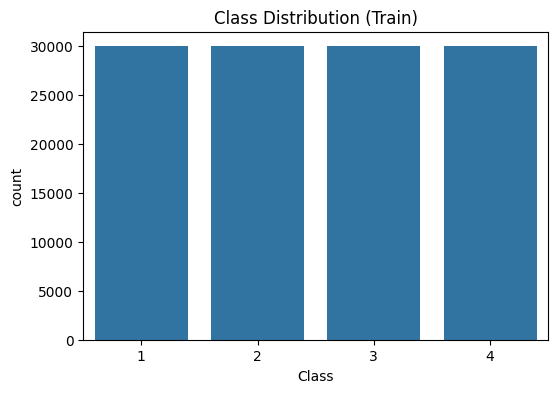

In [ ]:
#Data Preparation
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
# Use skiprows=1 to skip the header row directly from the CSV
train = pd.read_csv('/content/drive/My Drive/AGNews/train.csv', skiprows=1, names=['Class', 'Title', 'Description'])
test = pd.read_csv('/content/drive/My Drive/AGNews/test.csv', skiprows=1, names=['Class', 'Title', 'Description'])

# Convert 'Class' column to numeric
# Using errors='coerce' to turn any non-numeric values into NaN, though skiprows should prevent this
train['Class'] = pd.to_numeric(train['Class'], errors='coerce')
test['Class'] = pd.to_numeric(test['Class'], errors='coerce')

# Drop any rows where 'Class' became NaN due to coercion (shouldn't happen with skiprows=1 if data is clean)
train.dropna(subset=['Class'], inplace=True)
test.dropna(subset=['Class'], inplace=True)

# Convert 'Class' to integer type after ensuring no NaNs
train['Class'] = train['Class'].astype(int)
test['Class'] = test['Class'].astype(int)

# Inspect the shapes
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Display first few rows to check data
print(train.head())

# Check for missing values
print("Missing values in train:\n", train.isnull().sum())
print("Missing values in test:\n", test.isnull().sum())

# Simple cleaning function (expand as needed)
def clean_text(text):
    import re
    if pd.isna(text): # Handle potential NaN values after dropping rows
        return ""
    text = str(text).lower()                            # Lowercase and ensure string
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)     # Remove special chars
    return text

train['Title'] = train['Title'].apply(clean_text)
train['Description'] = train['Description'].apply(clean_text)
test['Title'] = test['Title'].apply(clean_text)
test['Description'] = test['Description'].apply(clean_text)

# Show sample data
print(train.head())

# Bar plot of class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=train)
plt.title('Class Distribution (Train)')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                               Title  \
0     wall st bears claw back into the black reuters   
1  carlyle looks toward commercial aerospace reuters   
2       oil and economy cloud stocks outlook reuters   
3  iraq halts oil exports from main southern pipe...   
4  oil prices soar to alltime record posing new m...   

                                        Title_tokens  
0      [wall, st, bears, claw, back, black, reuters]  
1  [carlyle, looks, toward, commercial, aerospace...  
2    [oil, economy, cloud, stocks, outlook, reuters]  
3  [iraq, halts, oil, exports, main, southern, pi...  
4  [oil, prices, soar, alltime, record, posing, n...  


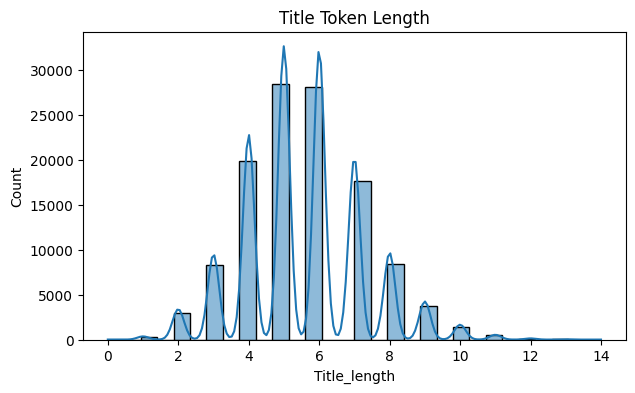

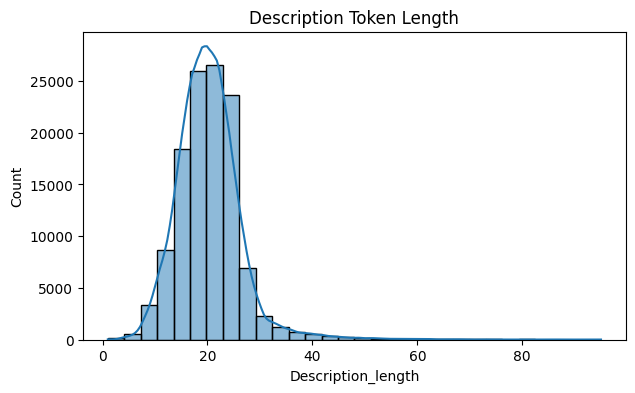

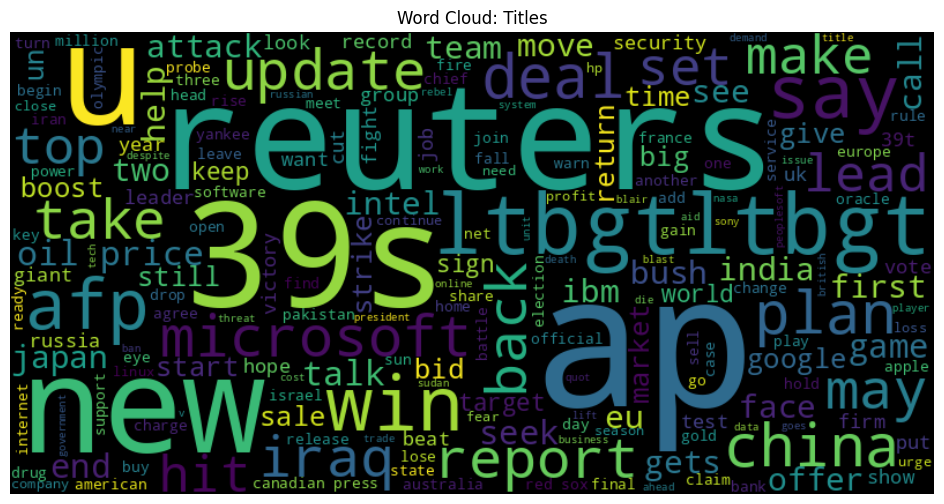

In [ ]:
#Text Processing
#Lowercase text (if not yet done),
#Remove special characters (if not yet done),
#Tokenize titles and descriptions,
#Optionally remove stopwords.
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Added to download the missing resource
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define a basic clean & tokenize function
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply to Title and Description columns, storing as new columns
train['Title_tokens'] = train['Title'].apply(clean_and_tokenize)
train['Description_tokens'] = train['Description'].apply(clean_and_tokenize)
test['Title_tokens'] = test['Title'].apply(clean_and_tokenize)
test['Description_tokens'] = test['Description'].apply(clean_and_tokenize)

# Check the result
print(train[['Title', 'Title_tokens']].head())

# Assuming tokenization from before
train['Title_length'] = train['Title_tokens'].apply(len)
train['Description_length'] = train['Description_tokens'].apply(len)

# Token length plot
plt.figure(figsize=(7,4))
sns.histplot(train['Title_length'], bins=30, kde=True)
plt.title('Title Token Length')
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(train['Description_length'], bins=30, kde=True)
plt.title('Description Token Length')
plt.show()

# Word Cloud of Title tokens
from wordcloud import WordCloud

def tokens_to_text(token_list_col):
    return ' '.join([word for tokens in token_list_col for word in tokens])

text = tokens_to_text(train['Title_tokens'])
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Titles')
plt.show()


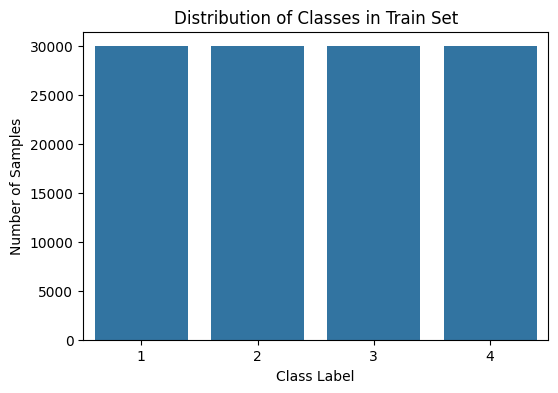

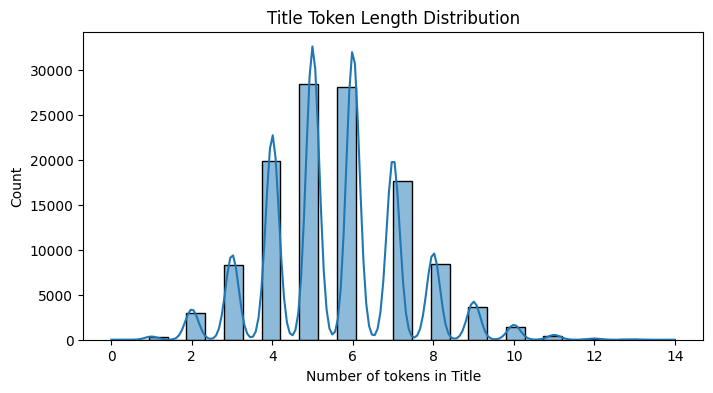

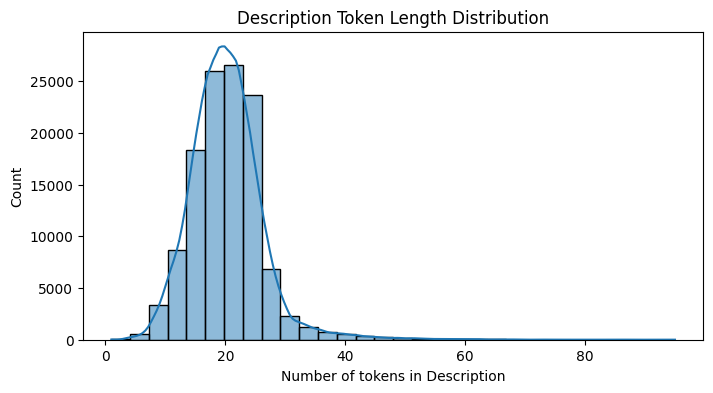

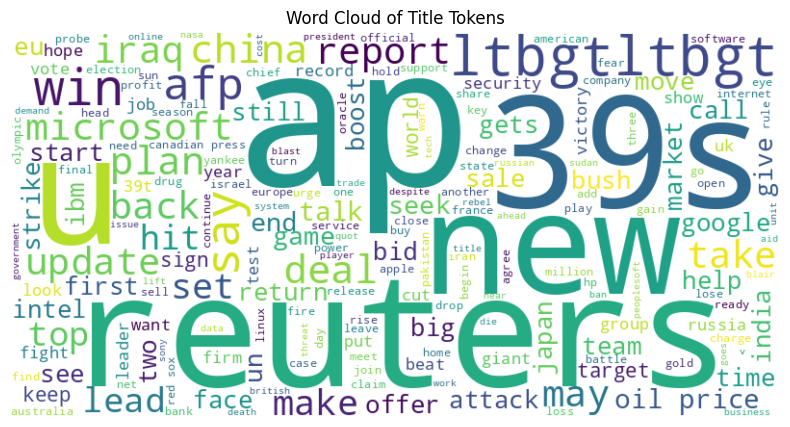

Bag-of-Words feature shape: (120000, 50)


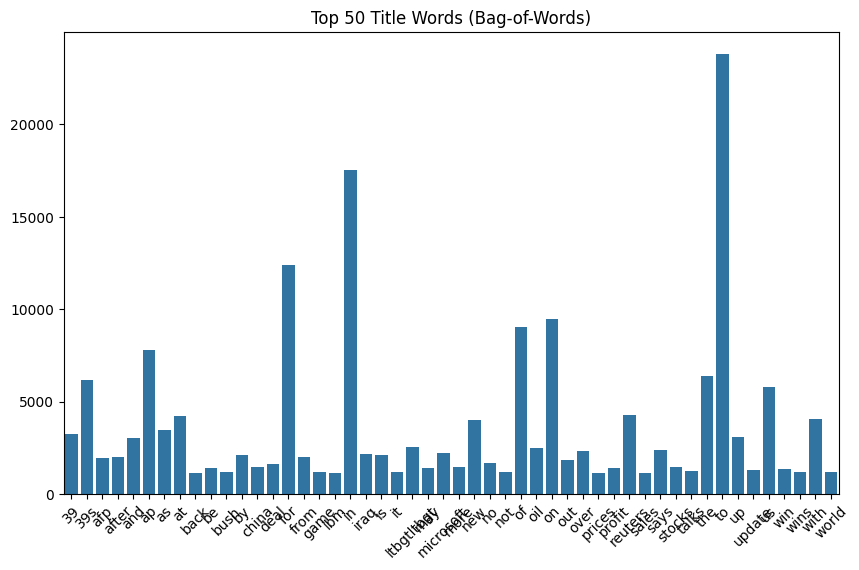

In [ ]:
#visualize key preprocessing outputs and distributions after tokenization
#Bar plot of how many samples per class label.
#Histograms for token lengths in titles and descriptions.
#Word cloud for most frequent title tokens.
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualize class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=train)
plt.title('Distribution of Classes in Train Set')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

# 2. Visualize article length (number of tokens)
train['Title_length'] = train['Title_tokens'].apply(len)
train['Description_length'] = train['Description_tokens'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(train['Title_length'], bins=30, kde=True)
plt.title('Title Token Length Distribution')
plt.xlabel('Number of tokens in Title')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(train['Description_length'], bins=30, kde=True)
plt.title('Description Token Length Distribution')
plt.xlabel('Number of tokens in Description')
plt.show()

# 3. Word cloud for most frequent words in titles
from wordcloud import WordCloud

def tokens_to_text(token_list_col):
    return ' '.join([word for tokens in token_list_col for word in tokens])

text_for_wordcloud = tokens_to_text(train['Title_tokens'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Title Tokens')
plt.show()

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=50)
X_title_bow = vectorizer.fit_transform(train['Title'])

# Show shape of feature matrix
print("Bag-of-Words feature shape:", X_title_bow.shape)

# Most frequent words
words = vectorizer.get_feature_names_out()
freqs = X_title_bow.sum(axis=0).A1

plt.figure(figsize=(10,6))
sns.barplot(x=words, y=freqs)
plt.xticks(rotation=45)
plt.title('Top 50 Title Words (Bag-of-Words)')
plt.show()


**Bag of Words**

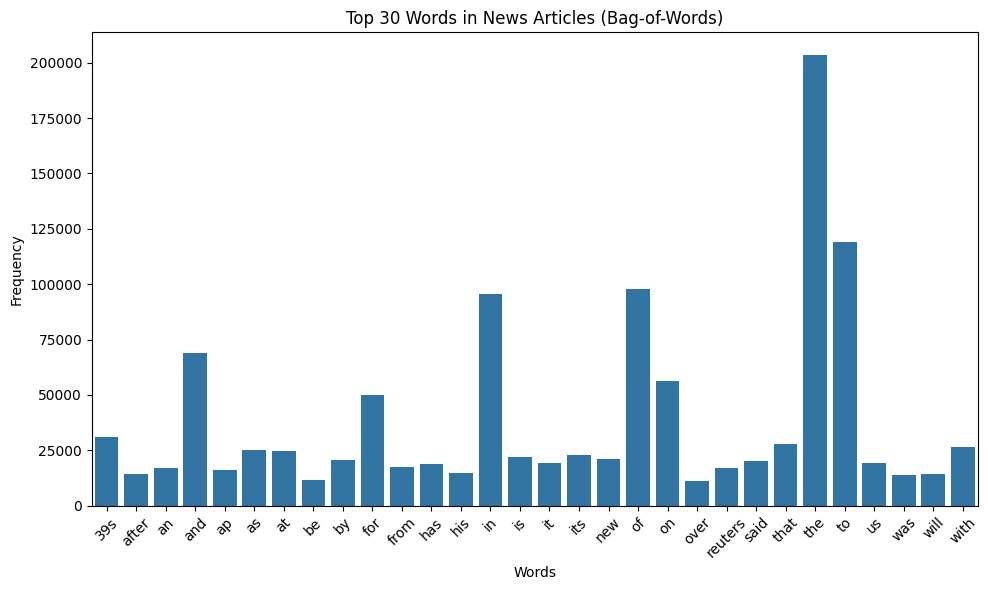

Bag-of-Words feature matrix shape: (120000, 30)
Bag-of-Words vector (sample): [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 1 0 0 0 0 0]]


In [ ]:
#Bag of Words (Vectorization)
#Vectorizes articles into numeric arrays (Bag-of-Words).
#Plots top 30 most frequent words.
#Displays matrix shape and a sample feature vector.
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Combine title and description for richer features
train['text'] = train['Title'] + ' ' + train['Description']

# Create Bag-of-Words features
vectorizer = CountVectorizer(max_features=30)
X_bow = vectorizer.fit_transform(train['text'])

# Get feature (word) names and their total frequency
words = vectorizer.get_feature_names_out()
freqs = X_bow.sum(axis=0).A1

# Bar plot for most common words in Bag-of-Words representation
plt.figure(figsize=(10,6))
sns.barplot(x=words, y=freqs)
plt.xticks(rotation=45)
plt.title('Top 30 Words in News Articles (Bag-of-Words)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Show Bag-of-Words matrix shape
print("Bag-of-Words feature matrix shape:", X_bow.shape)

# Optionally show a sample of Bag-of-Words features for first row
print("Bag-of-Words vector (sample):", X_bow[0].toarray())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 80.5 MB/s eta 0:00:00


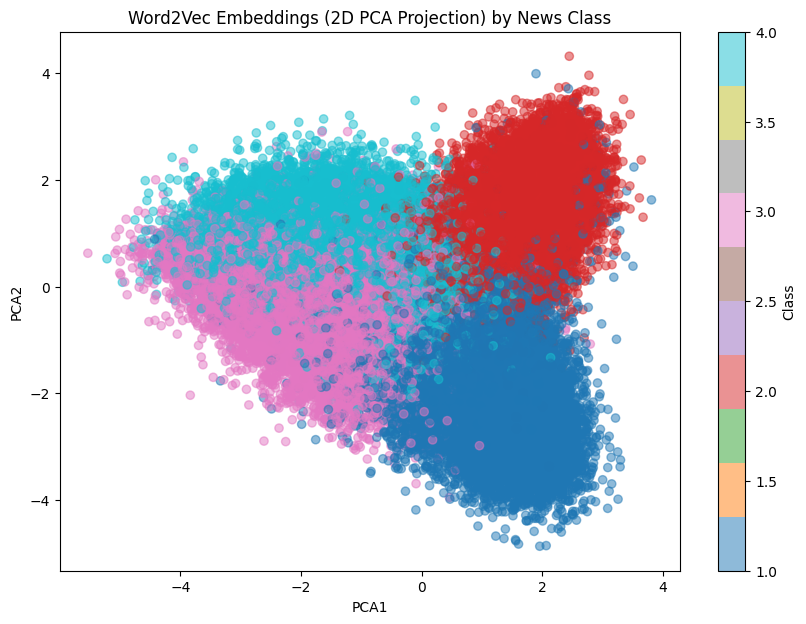

Word2Vec article matrix shape: (120000, 100)


In [ ]:
#Word2Vec
#Generate average Word2Vec vectors for each article
#Reduce them to 2D using PCA
#Visualize how the articles cluster by topic.
!pip install gensim --quiet

from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare data for gensim (list of token lists)
sentences = train['Title_tokens'].tolist() + train['Description_tokens'].tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Function to average word vectors for each row
def average_vector(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

# Create average vectors for each article (using title + description tokens)
train['tokens'] = train['Title_tokens'] + train['Description_tokens']
X_w2v = np.vstack(train.apply(lambda row: average_vector(row['tokens'], w2v_model, 100), axis=1))

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_w2v)

# Visualize Word2Vec vectors by class
plt.figure(figsize=(10,7))
scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=train['Class'], cmap='tab10', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Word2Vec Embeddings (2D PCA Projection) by News Class')
plt.colorbar(scatter, label='Class')
plt.show()

# Print shape as a check
print("Word2Vec article matrix shape:", X_w2v.shape)


**Glove Implementation**

In [ ]:
# Download GloVe (6B tokens, 100d vectors)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-11-17 04:55:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-17 04:55:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-17 04:55:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np

# Load GloVe vectors
def load_glove(file_path):
    glove = {}
    with open(file_path, encoding='utf8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vec = np.array(parts[1:], dtype='float32')
            glove[word] = vec
    return glove

glove_vectors = load_glove('glove.6B.100d.txt')


In [ ]:
#Generate average GloVe article vector
def average_glove_vector(tokens, glove, vector_size=100):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in glove:
            vec += glove[word]
            count += 1
    return vec / count if count > 0 else vec

X_glove = np.vstack(train['tokens'].apply(lambda tokens: average_glove_vector(tokens, glove_vectors, 100)))
print("GloVe article matrix shape:", X_glove.shape)


GloVe article matrix shape: (120000, 100)


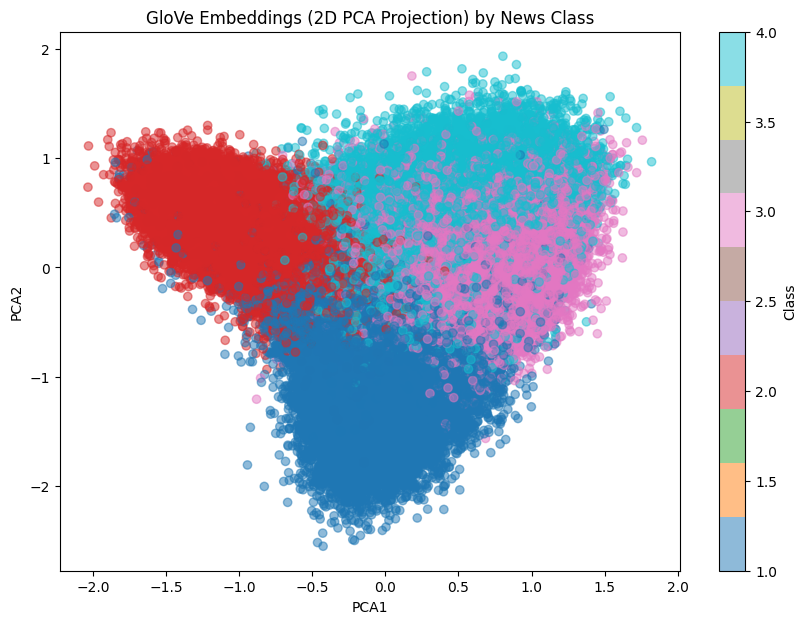

In [ ]:
#Visualize with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_glove_2d = pca.fit_transform(X_glove)

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_glove_2d[:,0], X_glove_2d[:,1], c=train['Class'], cmap='tab10', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('GloVe Embeddings (2D PCA Projection) by News Class')
plt.colorbar(scatter, label='Class')
plt.show()


**BERT**

In [ ]:
!pip install -q sentence-transformers

In [ ]:
#this section is commented out because BERT and similar transformer models do heavy computations on every text entry and my dataset is large (AG News typically has 120K+ items).
#Encoding text with BERT requires processing each sample through the model, which is slow, especially on CPU (faster on GPU, but still takes time).
#from this line below is the code!!!
#Generate BERT embeddings for news articles
#from sentence_transformers import SentenceTransformer
#import numpy as np

# Use mini model for speed; you can switch to 'all-MiniLM-L6-v2' for quality
#model = SentenceTransformer('all-MiniLM-L6-v2')

# Use either title, description, or concatenation for encoding
#text_data = (train['Title'] + " " + train['Description']).tolist()
#bert_embeddings = model.encode(text_data, show_progress_bar=True)
#print("BERT article matrix shape:", bert_embeddings.shape)


In [ ]:
# Install if needed: !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

# Use a lighter, faster model
fast_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

text_data = (train['Title'] + " " + train['Description']).tolist()[:2000]  # Sample for speed!
bert_embeddings_fast = fast_model.encode(text_data, show_progress_bar=True)
print("DistilBERT embedding shape:", bert_embeddings_fast.shape)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

DistilBERT embedding shape: (2000, 768)


In [ ]:
#This code will provide the visual representation of bert if used with full capacity
#Reduce embeddings to 2D using PCA and visualize
#from sklearn.decomposition import PCA
#import matplotlib.pyplot as plt


#pca = PCA(n_components=2)
#X_bert_2d = pca.fit_transform(bert_embeddings)


#plt.figure(figsize=(10,7))
#scatter = plt.scatter(X_bert_2d[:,0], X_bert_2d[:,1], c=train['Class'], cmap='tab10', alpha=0.5)
#plt.xlabel('PCA1')
#plt.ylabel('PCA2')
#plt.title('BERT Embeddings (2D PCA Projection) by News Class')
#plt.colorbar(scatter, label='Class')
#plt.show()

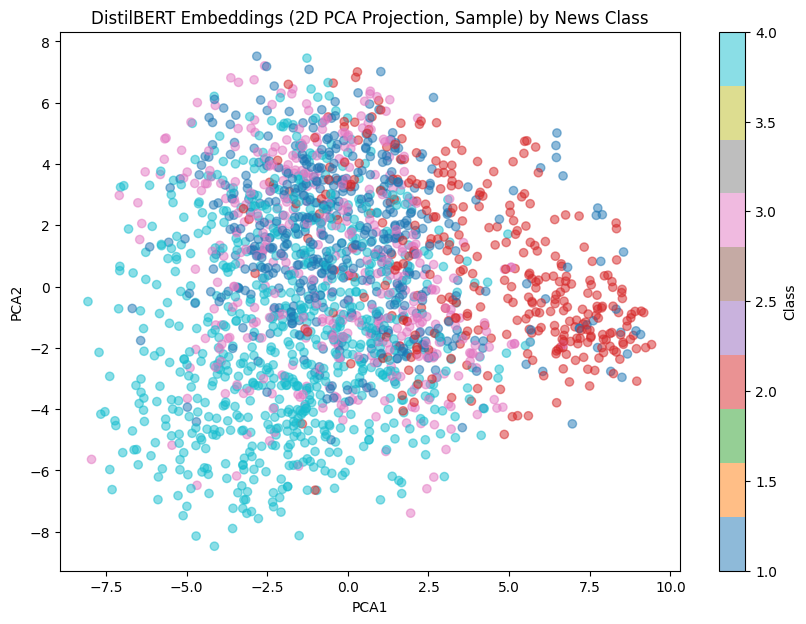

In [ ]:
#sample is used so the visual represtentation is less dense just to give an idea
#Reduce embeddings to 2D using PCA and visualize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D with PCA
pca = PCA(n_components=2)
X_distilbert_2d = pca.fit_transform(bert_embeddings_fast)

# Get class labels for the sample
sample_labels = train['Class'][:2000]

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_distilbert_2d[:,0], X_distilbert_2d[:,1], c=sample_labels, cmap='tab10', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('DistilBERT Embeddings (2D PCA Projection, Sample) by News Class')
plt.colorbar(scatter, label='Class')
plt.show()



**Model Training & Visual Evaluation (Classification and Confusion Matrix)**

Classification Report (Train):
               precision    recall  f1-score   support

           1       0.49      0.41      0.45     30000
           2       0.52      0.62      0.56     30000
           3       0.51      0.43      0.47     30000
           4       0.45      0.51      0.48     30000

    accuracy                           0.49    120000
   macro avg       0.49      0.49      0.49    120000
weighted avg       0.49      0.49      0.49    120000



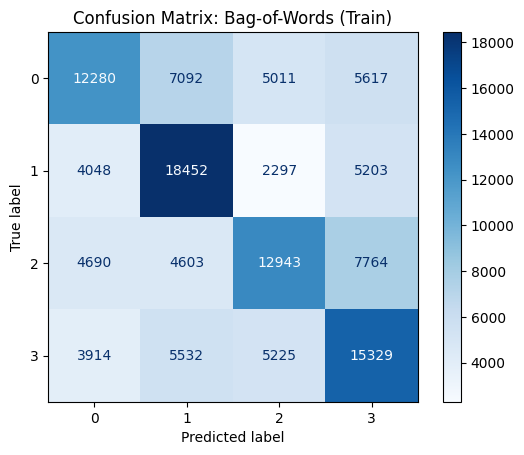

In [ ]:
#Bag of Words
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use X_bow from previous Bag-of-Words step and class labels
clf = LogisticRegression(max_iter=500)
clf.fit(X_bow, train['Class'])

# Predict on training set (for demonstration, normally you use test set)
pred_train = clf.predict(X_bow)

# Classification report
print("Classification Report (Train):\n", classification_report(train['Class'], pred_train))

# Confusion matrix
cm = confusion_matrix(train['Class'], pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Bag-of-Words (Train)')
plt.show()


In [ ]:
# Make sure you already have train['Title_tokens'] and train['Description_tokens']

from gensim.models import Word2Vec
import numpy as np

# Combine token lists for model training
sentences = train['Title_tokens'].tolist() + train['Description_tokens'].tolist()

# Train Word2Vec model (vector_size=100 is common)
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Create average Word2Vec vector per article (using both title and description tokens)
def average_vector(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

train['tokens'] = train['Title_tokens'] + train['Description_tokens']
X_w2v = np.vstack(train['tokens'].apply(lambda tokens: average_vector(tokens, w2v_model, 100)))

print("X_w2v shape:", X_w2v.shape)


X_w2v shape: (120000, 100)


Classification Report (Word2Vec, Train):
               precision    recall  f1-score   support

           1       0.90      0.88      0.89     30000
           2       0.94      0.96      0.95     30000
           3       0.85      0.85      0.85     30000
           4       0.85      0.85      0.85     30000

    accuracy                           0.88    120000
   macro avg       0.88      0.88      0.88    120000
weighted avg       0.88      0.88      0.88    120000



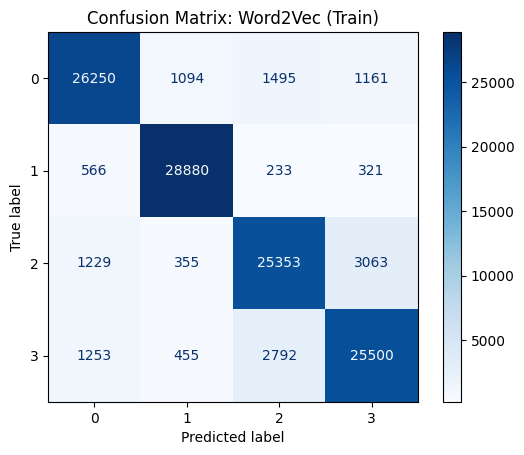

In [ ]:
#Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

clf_w2v = LogisticRegression(max_iter=500)
clf_w2v.fit(X_w2v, train['Class'])
pred_train_w2v = clf_w2v.predict(X_w2v)

# Performance metrics
print("Classification Report (Word2Vec, Train):\n", classification_report(train['Class'], pred_train_w2v))

cm_w2v = confusion_matrix(train['Class'], pred_train_w2v)
disp_w2v = ConfusionMatrixDisplay(confusion_matrix=cm_w2v)
disp_w2v.plot(cmap='Blues')
plt.title('Confusion Matrix: Word2Vec (Train)')
plt.show()


Classification Report (GloVe, Train):
               precision    recall  f1-score   support

           1       0.90      0.89      0.89     30000
           2       0.95      0.97      0.96     30000
           3       0.84      0.85      0.85     30000
           4       0.86      0.85      0.85     30000

    accuracy                           0.89    120000
   macro avg       0.89      0.89      0.89    120000
weighted avg       0.89      0.89      0.89    120000



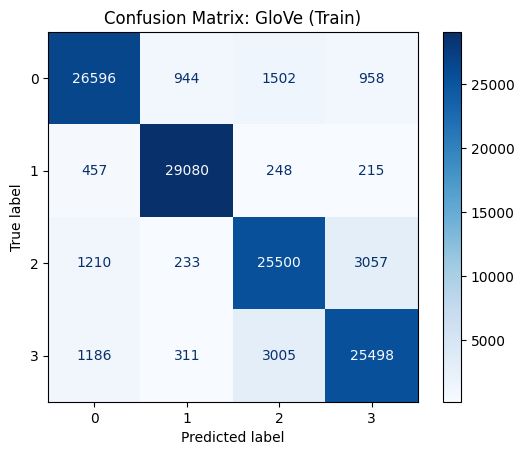

In [ ]:
#Glove
clf_glove = LogisticRegression(max_iter=500)
clf_glove.fit(X_glove, train['Class'])
pred_train_glove = clf_glove.predict(X_glove)

print("Classification Report (GloVe, Train):\n", classification_report(train['Class'], pred_train_glove))

cm_glove = confusion_matrix(train['Class'], pred_train_glove)
disp_glove = ConfusionMatrixDisplay(confusion_matrix=cm_glove)
disp_glove.plot(cmap='Blues')
plt.title('Confusion Matrix: GloVe (Train)')
plt.show()


In [ ]:
#this code will work with bert on full capacity
#clf_bert = LogisticRegression(max_iter=500)
#clf_bert.fit(bert_embeddings, train['Class'])
#pred_train_bert = clf_bert.predict(bert_embeddings)

#print("Classification Report (BERT, Train):\n", classification_report(train['Class'], pred_train_bert))

#cm_bert = confusion_matrix(train['Class'], pred_train_bert)
#disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert)
#disp_bert.plot(cmap='Blues')
#plt.title('Confusion Matrix: BERT (Train)')
#plt.show()


Classification Report (DistilBERT, Train Sample):
               precision    recall  f1-score   support

           1       1.00      0.97      0.99       477
           2       0.99      1.00      1.00       338
           3       0.98      0.97      0.97       408
           4       0.98      1.00      0.99       777

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2000



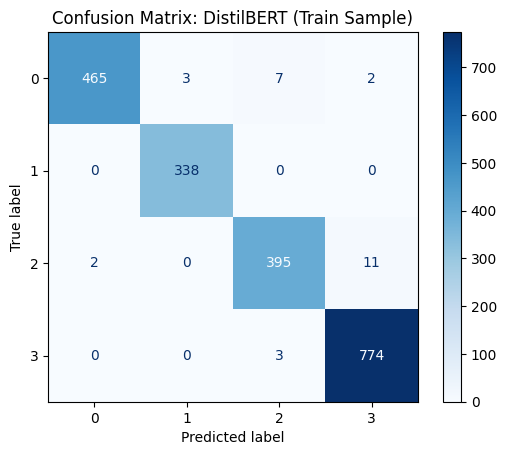

In [ ]:
#Again used with sample to give an idea
#BERT
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use only the first 2000 class labels to match the embeddings
sample_labels = train['Class'][:2000]

# Fit classifier on DistilBERT embeddings
clf_distilbert = LogisticRegression(max_iter=500)
clf_distilbert.fit(bert_embeddings_fast, sample_labels)
pred_train_distilbert = clf_distilbert.predict(bert_embeddings_fast)

# Show classification report
print("Classification Report (DistilBERT, Train Sample):\n", classification_report(sample_labels, pred_train_distilbert))

# Confusion matrix visualization
cm_distilbert = confusion_matrix(sample_labels, pred_train_distilbert)
disp_distilbert = ConfusionMatrixDisplay(confusion_matrix=cm_distilbert)
disp_distilbert.plot(cmap='Blues')
plt.title('Confusion Matrix: DistilBERT (Train Sample)')
plt.show()


